In [40]:
import os
import tensorflow as tf
import cv2
import joblib
from ops import *
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import quaternion as q

/home/obin/.local/lib/python3.5/site-packages/quaternion/calculus.py:475: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from scipy, which means that derivatives
and integrals will use less accurate finite-differencing
techniques.  You may want to install scipy.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [41]:
def arr_quat_to_rots(quats):
    ret = q.as_rotation_vector(q.as_quat_array(quats))
    ret = ret.reshape(-1,3)
    ret = ret[:,1]-3.14
    ret[np.where(ret > 3.14)] -= 6.28
    ret[np.where(ret < -3.14)] += 6.28
    return ret

In [2]:
batch_size = 4
GRU_size = 512
action_dim = 4
learning_rate = 1e-4
demo_length = 30
max_follow_length = 50
memory_dim = 1024
EPOCH = 500

In [50]:
os.listdir('preprocessed_habitat_data2/NOIESE')

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_habitat_data2/NOIESE'

In [49]:
joblib.load('preprocessed_habitat_data2/NOIESE/sT4fr6TAbpF_168_num0_0.dat.gz')

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_habitat_data2/NOIESE/sT4fr6TAbpF_168_num0_0.dat.gz'

In [53]:
DATA_DIR = 'preprocessed_habitat_data2'

train_list = [os.path.join(DATA_DIR,'NOISE',x) for x in os.listdir(os.path.join(DATA_DIR,'NOISE'))]
valid_list = [os.path.join(DATA_DIR,'valid',x) for x in os.listdir(os.path.join(DATA_DIR,'valid'))]

train_num = len(train_list)
valid_num = len(valid_list)
print('train_num {}, valid_num {}'.format(train_num, valid_num))
num_batches = int(train_num/batch_size)
print('num_batches {}'.format(num_batches))
valid_num_batches = int(valid_num/batch_size)
print('valid_num_batches {}'.format(valid_num_batches))


tf.reset_default_graph()
def load_data(data_path):

    noise_data = joblib.load(data_path)
    mode = 'train' if 'train' in str(data_path) else 'valid'
    ref_data_name = str(data_path).replace('NOISE', 'DEMON')
    ref_data_name = ref_data_name[:ref_data_name.find('.dat.gz')-1] + '0.dat.gz'
    #ref_data = joblib.load(str(ref_data_name)[2:])
    ref_data = joblib.load(str(ref_data_name))

    noise_rgb  = np.array(noise_data['rgb'],dtype=np.float32)/255.0 * 2 - 1
    ref_rgb = np.array(ref_data['rgb'],dtype=np.float32)/255.0 * 2 - 1

    noise_data['action'] = np.array(noise_data['action'])
    ref_data['action'] = np.array(ref_data['action'])

    a = np.where(noise_data['action']>5)
    b = np.where(ref_data['action']>5)
    noise_data['action'][a] = noise_data['action'][a] - 5
    ref_data['action'][b] = ref_data['action'][b] - 5

    noise_action = np.eye(action_dim)[noise_data['action']]
    ref_action = np.eye(action_dim)[ref_data['action']]

    add_t = max_follow_length - len(noise_rgb)
    if add_t < 0 : 
        noise_rgb = noise_rgb[:max_follow_length]
        noise_action = noise_action[:max_follow_length]
        action_mask = np.ones_like(noise_action)
        action_mask = action_mask[:max_follow_length]
        print('its weird..', data_path)

    else:
        img_size = noise_rgb[0].shape[1]
        action_mask = np.ones_like(noise_action)

        noise_rgb = np.concatenate([noise_rgb, np.zeros([add_t, img_size, img_size, 3])],0)
        noise_action = np.concatenate([noise_action, np.zeros([add_t, action_dim])],0)
        action_mask = np.concatenate([action_mask, np.zeros([add_t, action_dim])],0)

    result = [ref_rgb, ref_action, noise_rgb, noise_action, action_mask]
    return [np.array(x,dtype=np.float32) for x in result]


train_num 6108, valid_num 0
num_batches 1527
valid_num_batches 0


In [5]:
def draw_action(img, act):
    if act == 1 : angle = 0
    elif act == 2 : angle = 1
    elif act == 3 : angle = -1
    else : return img
    cv2.line(img,(128,256),(int(128-40*angle),256-40),(255,0,0),3)
    return img

In [ ]:
for i in range(len(train_list)):
    [ref_rgb, ref_action, noise_rgb, noise_action, action_mask] = load_data(train_list[i])
    for j in range(max_follow_length):
        view_img = np.zeros([256,256*2,3])
        ref = draw_action(ref_rgb[j],np.argmax(ref_action[j])) if j < demo_length else np.zeros_like(ref_rgb[-1])
        view_img[:,:256,:] = ref
        noise = draw_action(noise_rgb[j],np.argmax(noise_action[j]))
        view_img[:,256:,:] = noise
        #cv2.imshow('hi',view_img)
        #cv2.waitKey(100)
        print(train_list[i])
        plt.imshow((view_img+1)/2.)
        plt.show()
        break
    #if i > 100 : break
        

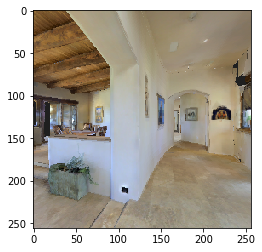

In [36]:
a = joblib.load('preprocessed_habitat_data/train/ac26ZMwG7aT_218_2.dat.gz')
plt.imshow(a['rgb'][0])
plt.show()

In [37]:
print(a['position'][0])
print(a['rotation'][0])

[0.01776783 0.06737331 0.70470196]
[0.30614024 0.         0.95198643 0.        ]


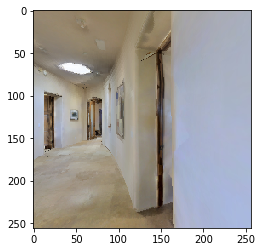

In [28]:
b = joblib.load('preprocessed_habitat_data/DEMON/ac26ZMwG7aT_218_0.dat.gz')
plt.imshow(b['rgb'][0])
plt.show()

In [29]:
print(b['position'][0])
print(b['rotation'][0])

[ 3.65403581  0.139222   -3.13214207]
[-0.88436294  0.          0.46680003  0.        ]


In [39]:
np.linalg.norm(a['position'][0] - b['position'][0])

5.286679405261184

In [43]:
rots = arr_quat_to_rots(a['rotation'][0])
start_rots = arr_quat_to_rots(b['rotation'][0])
start_rot_norms = rots - start_rots

start_rot_norms[np.where(start_rot_norms > 3.14)] -= 6.28
start_rot_norms[np.where(start_rot_norms < -3.14)] += 6.28
start_rot_norms


array([-2.79252675])